In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats
import random
import re
import utilities as ut
import modularised_utils as mut
import evaluation_utils as evut

sns.set_theme(style="whitegrid")
seed = 42
np.random.seed(seed)

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
experiment = 'slc'
path = f"data/{experiment}/results_empirical"
saved_folds = joblib.load(f"data/{experiment}/cv_folds.pkl")

In [3]:
# # Load the dictionaries containing the results for each optimization method
# diroca_results_empirical = joblib.load(f"{path}/diroca_cv_results_empirical.pkl")
# gradca_results_empirical = joblib.load(f"{path}/gradca_cv_results_empirical.pkl")
# baryca_results_empirical = joblib.load(f"{path}/baryca_cv_results_empirical.pkl")
# abslingam_results_empirical = joblib.load(f"{path}/abslingam_cv_results_empirical.pkl")


# print("Successfully loaded results for all optimization methods.")
# print(f"  - DIROCA results keys: {list(diroca_results_empirical.keys())}")
# print(f"  - GradCA results keys: {list(gradca_results_empirical.keys())}")
# print(f"  - BARYCA results keys: {list(baryca_results_empirical.keys())}")
# print(f"  - Abs-LiNGAM results keys: {list(abslingam_results_empirical.keys())}")

# results_to_evaluate = {}

# # --- Add the baseline methods first ---
# results_to_evaluate['GradCA'] = gradca_results_empirical
# results_to_evaluate['BARYCA'] = baryca_results_empirical
# results_to_evaluate['AbsLiNGAM'] = abslingam_results_empirical

# # --- Unpack each DIROCA hyperparameter run into its own "method" ---
# # First, find all the different DIROCA runs you tested (e.g., 'eps_delta_2', 'eps_delta_4')
# # We can find them by looking at the keys in the first fold's results.
# if diroca_results_empirical:
#     first_fold_key = list(diroca_results_empirical.keys())[0]
#     diroca_run_ids = list(diroca_results_empirical[first_fold_key].keys())

#     # Now, create a separate entry for each DIROCA run
#     for run_id in diroca_run_ids:
#         # Create a new, descriptive name for this method, e.g., "DIROCA (eps_delta_8)"
#         method_name = f"DIROCA ({run_id})"
        
#         # Create a new dictionary that will only contain the results for this specific run_id
#         new_diroca_dict = {}
#         for fold_key, fold_results in diroca_results_empirical.items():
#             # For each fold, just grab the data for the current run_id
#             if run_id in fold_results:
#                 new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
        
#         # Add this new, filtered dictionary to our main evaluation dictionary
#         results_to_evaluate[method_name] = new_diroca_dict

# print("\nMethods available for evaluation:")
# for key in results_to_evaluate.keys():
#     print(f"  - {key}")

In [4]:
# ======================================================================
# 1. Load All Results Files
# ======================================================================
# (This part of your code is correct and remains the same)
diroca_results_empirical = joblib.load(f"{path}/diroca_cv_results_empirical.pkl")
gradca_results_empirical = joblib.load(f"{path}/gradca_cv_results_empirical.pkl")
baryca_results_empirical = joblib.load(f"{path}/baryca_cv_results_empirical.pkl")
abslingam_results_empirical = joblib.load(f"{path}/abslingam_cv_results_empirical.pkl")

all_data = ut.load_all_data(experiment)
print("✅ Successfully loaded all empirical and baseline results.")

# ======================================================================
# 2. Restructure and Relabel the Results
# ======================================================================
results_to_evaluate = {}

# --- Add the standard baseline methods ---
results_to_evaluate['GradCA'] = gradca_results_empirical
results_to_evaluate['BARYCA'] = baryca_results_empirical

# --- Unpack the two Abs-LiNGAM styles into separate methods ---
if abslingam_results_empirical:
    first_fold_key = list(abslingam_results_empirical.keys())[0]
    for style in abslingam_results_empirical[first_fold_key].keys():
        method_name = f"Abs-LiNGAM ({style})"
        new_abslingam_dict = {}
        for fold_key, fold_results in abslingam_results_empirical.items():
            if style in fold_results:
                new_abslingam_dict[fold_key] = {style: fold_results[style]}
        results_to_evaluate[method_name] = new_abslingam_dict

# --- THIS IS THE MODIFIED SECTION for DIROCA ---
# This helper function now creates the simplified labels
def create_diroca_label(run_id):
    """Parses a run_id and creates a simplified label if epsilon and delta are equal."""
    # Use regular expression to find numbers for epsilon and delta
    matches = re.findall(r'(\d+\.?\d*)', run_id)
    if len(matches) == 2:
        eps, delta = matches
        # If they are the same, use the simplified format
        if eps == delta:
            # Handle integer conversion for clean labels like '1' instead of '1.0'
            val = int(float(eps)) if float(eps).is_integer() else float(eps)
            return f"DIROCA (eps_delta_{val})"
    # Otherwise, or if parsing fails, use the full original name
    return f"DIROCA ({run_id})"

# Unpack each DIROCA hyperparameter run with the new, clean label
if diroca_results_empirical:
    first_fold_key = list(diroca_results_empirical.keys())[0]
    for run_id in diroca_results_empirical[first_fold_key].keys():
        method_name = create_diroca_label(run_id) # Use the new helper to create the name
        new_diroca_dict = {}
        for fold_key, fold_results in diroca_results_empirical.items():
            if run_id in fold_results:
                new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
        results_to_evaluate[method_name] = new_diroca_dict

print("\n✓ Restructured results with simplified labels.")
print("Methods available for evaluation:")
for key in sorted(results_to_evaluate.keys()):
    print(f"  - {key}")

Data loaded for 'slc'.
✅ Successfully loaded all empirical and baseline results.

✓ Restructured results with simplified labels.
Methods available for evaluation:
  - Abs-LiNGAM (Noisy)
  - Abs-LiNGAM (Perfect)
  - BARYCA
  - DIROCA (eps_0.107_delta_0.035)
  - DIROCA (eps_delta_1)
  - DIROCA (eps_delta_2)
  - DIROCA (eps_delta_4)
  - DIROCA (eps_delta_8)
  - GradCA


In [5]:
label_map_empirical = {
                        'DIROCA (eps_0.328_delta_0.107)': 'DiRoCA_star',
                        'DIROCA (eps_delta_1)': 'DIROCA_1',
                        'DIROCA (eps_delta_2)': 'DIROCA_2',
                        'DIROCA (eps_delta_4)': 'DIROCA_4',
                        'DIROCA (eps_delta_8)': 'DIROCA_8',
                        'GradCA': 'GradCA',
                        'BARYCA': 'BARYCA',
                        'Abs-LiNGAM (Perfect)': 'Abslin_p',
                        'Abs-LiNGAM (Noisy)': 'Abslin_n'
                    }

results_to_evaluate = {label_map_empirical.get(key, key): value for key, value in results_to_evaluate.items()}


In [6]:
results_to_evaluate.keys()

dict_keys(['GradCA', 'BARYCA', 'Abslin_p', 'Abslin_n', 'DIROCA (eps_0.107_delta_0.035)', 'DIROCA_1', 'DIROCA_2', 'DIROCA_4', 'DIROCA_8'])

In [7]:
# Load the original data dictionary
all_data      = ut.load_all_data(experiment)

Dll_samples   = all_data['LLmodel']['data']
Dhl_samples   = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega         = all_data['abstraction_data']['omega']
ll_var_names  = list(all_data['LLmodel']['graph'].nodes())
hl_var_names  = list(all_data['HLmodel']['graph'].nodes())

Data loaded for 'slc'.


In [8]:
results_to_evaluate.keys()

dict_keys(['GradCA', 'BARYCA', 'Abslin_p', 'Abslin_n', 'DIROCA (eps_0.107_delta_0.035)', 'DIROCA_1', 'DIROCA_2', 'DIROCA_4', 'DIROCA_8'])

In [9]:
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    """
    Calculates the abstraction error directly on the endogenous data samples
    by computing a matrix norm between the transformed LL data and the HL data.
    
    Args:
        T_matrix (np.ndarray): The learned abstraction matrix.
        Dll_test (np.ndarray): The low-level endogenous test samples.
        Dhl_test (np.ndarray): The high-level endogenous test samples.
        metric (str): The distance metric to use (e.g., 'fro', 'l1', 'nuclear').
        
    Returns:
        float: The calculated empirical distance.
    """
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan # Cannot compute error on empty data

    try:
        # 1. Transform the low-level data samples using the learned T matrix
        Dhl_predicted = Dll_test @ T_matrix.T
        
        # 2. Compute the direct distance between the predicted and actual data matrices.
        #    NOTE: We transpose the matrices here to match the expected input
        #          of your original compute_empirical_distance function.
        error = evut.compute_empirical_distance(Dhl_predicted.T, Dhl_test.T, metric)
        
    except Exception as e:
        print(f"  - Warning: Could not compute empirical distance. Error: {e}. Returning NaN.")
        return np.nan

    return error

## F-contamination

In [10]:
def contaminate_data(data, strength, contamination_type, num_segments=10, seed=None):
    """
    Applies a specified contamination to data samples to simulate model misspecification.

    Args:
        data (np.ndarray): The original data samples.
        strength (float): The magnitude of the contamination.
        contamination_type (str): 'piecewise', 'multiplicative', or 'nonlinear'.
        num_segments (int): Number of segments for the 'piecewise' type.
        seed (int, optional): Random seed for reproducibility.
        
    Returns:
        np.ndarray: The contaminated data.
    """
    rng = np.random.default_rng(seed)
    data_cont = data.copy()
    
    if contamination_type == "multiplicative":
        # Apply element-wise multiplicative noise
        noise = rng.uniform(low=1.0 - strength, high=1.0 + strength, size=data.shape)
        data_cont *= noise
  
    elif contamination_type == "nonlinear":
        # Apply a sine-based non-linear distortion
        data_cont += strength * np.sin(data_cont)
  
    elif contamination_type == "piecewise":
        # Apply piecewise contamination to each column (variable)
        for col_idx in range(data.shape[1]):
            column = data_cont[:, col_idx]
            breakpoints = np.quantile(column, q=np.linspace(0, 1, num_segments + 1))
            breakpoints[-1] += 1e-6 # Ensure the last element is included
            
            for i in range(num_segments):
                factor = 1.0 + rng.uniform(low=-strength, high=strength)
                mask = (column >= breakpoints[i]) & (column < breakpoints[i+1])
                data_cont[mask, col_idx] *= factor
  
    else:
        raise ValueError(f"Unknown contamination type: {contamination_type}")
  
    return data_cont

In [11]:
# Choose which type of non-linearity to test
contamination_type_to_run = 'multiplicative' # Options: 'piecewise', 'multiplicative', 'nonlinear'

# Define the range of contamination strengths to test
contamination_strengths = np.linspace(0, 1, 10) 

# Number of random contaminations to average over for each setting
num_trials = 10

f_spec_records = []
print(f"F '{contamination_type_to_run}' misspecification evaluation")

for strength in tqdm(contamination_strengths, desc="Contamination Strength"):
    for trial in range(num_trials):
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict.get(f'fold_{i}', {})
                for run_key, run_data in fold_results.items():

                    if 'DIROCA' in method_name:
                        method_label = method_name
                    else:
                        method_label = method_name

                    T_learned = run_data['T_matrix']
                    test_indices = run_data['test_indices']
                    
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test_clean = Dll_samples[iota][test_indices]
                        Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
                        
                        Dll_test_cont = contaminate_data(Dll_test_clean, strength, contamination_type_to_run, seed=trial)
                        Dhl_test_cont = contaminate_data(Dhl_test_clean, strength, contamination_type_to_run, seed=trial)
                        
                        error = calculate_empirical_error(T_learned, Dll_test_cont, Dhl_test_cont)
                        if not np.isnan(error):
                            errors_per_intervention.append(error)
                    
                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    
                    record = {
                        'method': method_label, 
                        'contamination': strength,
                        'trial': trial,
                        'fold': i,
                        'error': avg_error
                    }
                    f_spec_records.append(record)

f_spec_df = pd.DataFrame(f_spec_records)
print("--- F-Misspecification Evaluation Complete ---")

F 'multiplicative' misspecification evaluation


Contamination Strength: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

--- F-Misspecification Evaluation Complete ---


In [12]:
# plt.figure(figsize=(12, 8))
# sns.lineplot(data=f_spec_df, x='contamination', y='error', hue='method', marker='o', errorbar=('ci', 95))
# plt.title(f'Robustness to F-Misspecification ({contamination_type_to_run})', fontsize=16)
# plt.xlabel('Contamination Strength', fontsize=12)
# plt.ylabel('Average Abstraction Error', fontsize=12)
# plt.show()

print("\n" + "="*65)
print(f"Overall Performance (Averaged Across All '{contamination_type_to_run}' Strengths)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean Error ± 95% CI'}")
print("="*65)

summary = f_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std'] #/ np.sqrt(summary['count'])
# summary['ci95'] = 1.96 * summary['sem']
summary['ci95'] = summary['sem']

for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")
print("="*65)


Overall Performance (Averaged Across All 'multiplicative' Strengths)
Method/Run                          | Mean Error ± 95% CI
GradCA                              | 63.1590 ± 5.4351
DIROCA_1                            | 69.7332 ± 4.9434
DIROCA_2                            | 70.7777 ± 4.0304
DIROCA_4                            | 70.7777 ± 4.0304
DIROCA_8                            | 70.7777 ± 4.0304
BARYCA                              | 95.4702 ± 8.7866
DIROCA (eps_0.107_delta_0.035)      | 97.6368 ± 9.0061
Abslin_n                            | 101.4545 ± 8.6654
Abslin_p                            | 103.8440 ± 10.8534


## ω contamination

In [13]:
def contaminate_omega_map(original_omega, num_misalignments):
    
    """Randomly re-wires a subset of entries in the omega map."""
    
    omega_keys = [k for k in original_omega.keys() if k is not None]
    omega_vals = [original_omega[k] for k in omega_keys if original_omega[k] is not None]

    contaminated_omega = original_omega.copy()
    
    # Bound the number of misalignments by the number of eligible keys.
    num_to_corrupt = min(num_misalignments, len(omega_keys))
    # Randomly select keys to corrupt.
    to_corrupt = random.sample(omega_keys, k=num_to_corrupt)
    
    # Create a random permutation of available targets (ensuring change)
    # Use the set of targets from eligible keys.
    all_targets = list(set(omega_vals))

    for key in to_corrupt:
        original_target = original_omega[key]
        # Only corrupt if there's an alternative available.
        available_targets = [t for t in all_targets if t != original_target]
        if available_targets:
            new_target = random.choice(available_targets)
            contaminated_omega[key] = new_target
            
    return contaminated_omega

Omega-misspecification evaluation


Misalignment Level:   0%|          | 0/6 [00:00<?, ?it/s]

Misalignment Level: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]




--- Omega-Misspecification Evaluation Complete ---


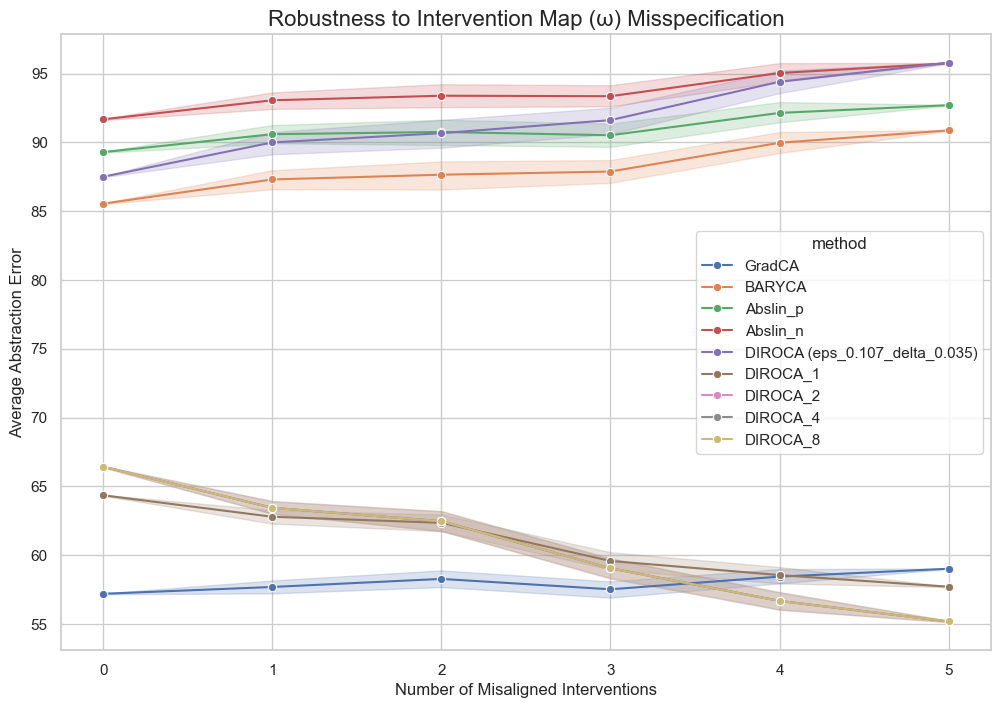


Overall Performance (Averaged Across All Misalignment Levels)
Method/Run                          | Mean Error ± 95% CI
GradCA                              | 58.0151 ± 2.4522
DIROCA_2                            | 60.5329 ± 4.7391
DIROCA_4                            | 60.5329 ± 4.7391
DIROCA_8                            | 60.5329 ± 4.7391
DIROCA_1                            | 60.8815 ± 3.4343
BARYCA                              | 88.2019 ± 3.9244
Abslin_p                            | 90.9982 ± 3.4556
DIROCA (eps_0.107_delta_0.035)      | 91.6625 ± 4.7158
Abslin_n                            | 93.7087 ± 3.3073


In [14]:
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ======================================================================
# 1. CONTROL PANEL
# ======================================================================

# Test from 0 misalignments up to all but one
max_misalignments = len(I_ll_relevant) # Leave at least one correct mapping
misalignment_levels = range(0, max_misalignments)
#misalignment_levels = np.linspace(0, max_misalignments, 11, dtype=int)

# Number of random contaminations to average over for each setting
num_trials = 20

# ======================================================================
# 2. EVALUATION LOOP
# ======================================================================
omega_spec_records = []
print("Omega-misspecification evaluation")

for num_misalignments in tqdm(misalignment_levels, desc="Misalignment Level"):
    for trial in range(num_trials):
        # Create a new scrambled omega map for each trial
        omega_cont = contaminate_omega_map(omega, num_misalignments)
        
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict.get(f'fold_{i}', {})
                for run_key, run_data in fold_results.items():

                    # --- Create a single, clean label for the method/run combination ---
                    if 'DIROCA' in method_name:
                        method_label = method_name
                    else:
                        method_label = method_name
                    # --- END OF CHANGE ---

                    T_learned = run_data['T_matrix']
                    test_indices = run_data['test_indices']
                    
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test = Dll_samples[iota][test_indices]
                        # Use the contaminated omega map
                        Dhl_test = Dhl_samples[omega_cont[iota]][test_indices]
                        
                        error = calculate_empirical_error(T_learned, Dll_test, Dhl_test)
                        if not np.isnan(error): errors_per_intervention.append(error)
                    
                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    
                    # Store a detailed record using the new method_label
                    record = {
                        'method': method_label, # <-- Use the new clean label
                        'misalignments': num_misalignments,
                        'trial': trial,
                        'fold': i,
                        'error': avg_error
                    }
                    omega_spec_records.append(record)

omega_spec_df = pd.DataFrame(omega_spec_records)
print("\n\n--- Omega-Misspecification Evaluation Complete ---")

# ======================================================================
# 3. ANALYSIS AND PLOTTING
# ======================================================================

# a. Plot the Robustness Curve (now with a clean legend)
plt.figure(figsize=(12, 8))
sns.lineplot(data=omega_spec_df, x='misalignments', y='error', hue='method', marker='o', errorbar=('ci', 95))
plt.title('Robustness to Intervention Map (ω) Misspecification', fontsize=16)
plt.xlabel('Number of Misaligned Interventions', fontsize=12)
plt.ylabel('Average Abstraction Error', fontsize=12)
plt.show()

# b. Print the Final Summary Table (now grouped only by method)
print("\n" + "="*65)
print("Overall Performance (Averaged Across All Misalignment Levels)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean Error ± 95% CI'}")
print("="*65)

summary = omega_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std'] #/ np.sqrt(summary['count'])
# summary['ci95'] = 1.96 * summary['sem']
summary['ci95'] = summary['sem']

for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")
print("="*65)

In [15]:
# b. Print the Final Summary Table (now grouped only by method)
print("\n" + "="*65)
print("Overall Performance (Averaged Across All Misalignment Levels)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean Error ± 95% CI'}")
print("="*65)

summary = omega_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std'] #/ np.sqrt(summary['count'])
# summary['ci95'] = 1.96 * summary['sem']
summary['ci95'] = summary['sem']

for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")
print("="*65)


Overall Performance (Averaged Across All Misalignment Levels)
Method/Run                          | Mean Error ± 95% CI
GradCA                              | 58.0151 ± 2.4522
DIROCA_2                            | 60.5329 ± 4.7391
DIROCA_4                            | 60.5329 ± 4.7391
DIROCA_8                            | 60.5329 ± 4.7391
DIROCA_1                            | 60.8815 ± 3.4343
BARYCA                              | 88.2019 ± 3.9244
Abslin_p                            | 90.9982 ± 3.4556
DIROCA (eps_0.107_delta_0.035)      | 91.6625 ± 4.7158
Abslin_n                            | 93.7087 ± 3.3073


In [17]:
# b. Print the Final Summary Table (now grouped only by method)
print("\n" + "="*65)
print("Overall Performance (Averaged Across All Misalignment Levels)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean Error ± 95% CI'}")
print("="*65)

summary = omega_spec_df.groupby('method')['error'].agg(['mean', 'std', 'count'])
summary['sem'] = summary['std'] #/ np.sqrt(summary['count'])
# summary['ci95'] = 1.96 * summary['sem']
summary['ci95'] = summary['sem']

for method_name, row in summary.sort_values('mean').iterrows():
    print(f"{method_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")
print("="*65)


Overall Performance (Averaged Across All Misalignment Levels)
Method/Run                          | Mean Error ± 95% CI
DIROCA_4                            | 454.0207 ± 6.6895
DIROCA_8                            | 454.0950 ± 6.6516
DIROCA_2                            | 454.9778 ± 5.8279
DIROCA_1                            | 460.4121 ± 5.4232
Abslin_n                            | 496.8590 ± 4.8516
GradCA                              | 548.5348 ± 5.0042
Abslin_p                            | 577.6946 ± 4.3352
DiRoCA_star                         | 677.6576 ± 4.8882
BARYCA                              | 732.5498 ± 5.2162


SyntaxError: invalid syntax (2046678379.py, line 1)

100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


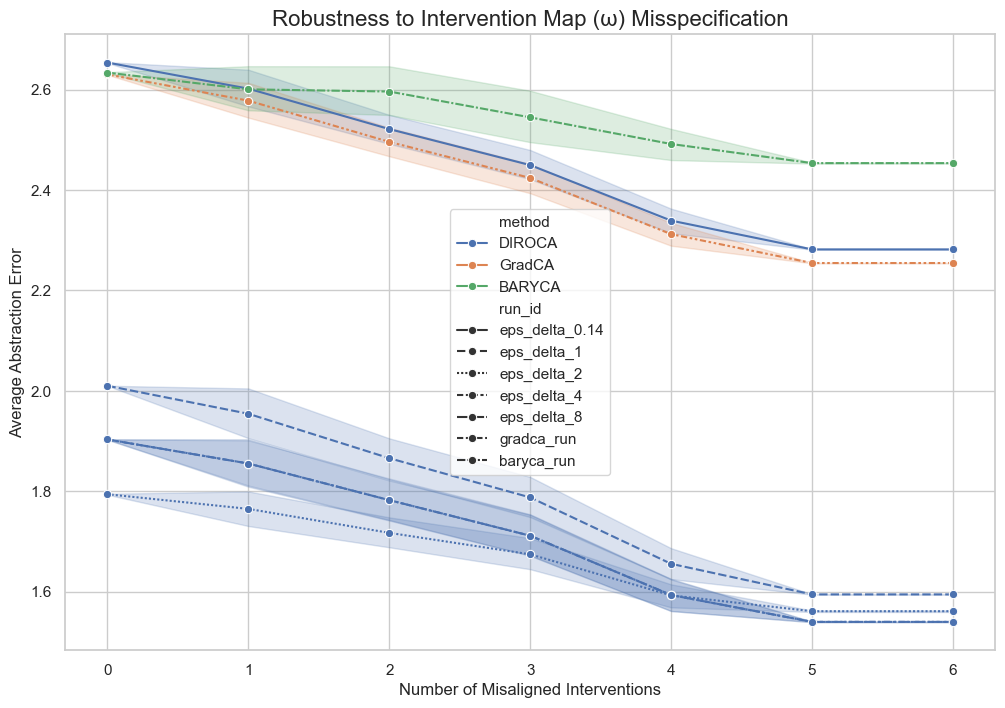


Overall Performance (Averaged Across All Misalignment Levels)
Method/Run                          | Mean Error ± Std Dev

--- Overall Omega-Misspecification Performance ---
BARYCA (baryca_run)                 | 2.5498 ± 0.0163
DIROCA (eps_delta_0.14)             | 2.4645 ± 0.0213
DIROCA (eps_delta_1)                | 1.7993 ± 0.0249
DIROCA (eps_delta_2)                | 1.6767 ± 0.0151
DIROCA (eps_delta_4)                | 1.7202 ± 0.0227
DIROCA (eps_delta_8)                | 1.7202 ± 0.0227
GradCA (gradca_run)                 | 2.4389 ± 0.0215


In [18]:
max_misalignments   = len(I_ll_relevant)
misalignment_levels = np.linspace(0, max_misalignments, 10, dtype=int)

num_trials           = 10

omega_spec_records = []
for num_misalignments in tqdm(misalignment_levels):
    for trial in range(num_trials):
        # Create a new scrambled omega map for each trial
        omega_cont = contaminate_omega_map(omega, num_misalignments)
        
        for i, fold_info in enumerate(saved_folds):
            for method_name, results_dict in results_to_evaluate.items():
                fold_results = results_dict[f'fold_{i}']
                for run_key, run_data in fold_results.items():
                    T_learned, test_indices = run_data['T_matrix'], run_data['test_indices']
                    
                    errors_per_intervention = []
                    for iota in I_ll_relevant:
                        Dll_test = Dll_samples[iota][test_indices]
                        # Use the contaminated omega map
                        Dhl_test = Dhl_samples[omega_cont[iota]][test_indices]
                        
                        error = calculate_abstraction_error(T_learned, Dll_test, Dhl_test)
                        if not np.isnan(error): errors_per_intervention.append(error)
                    
                    avg_error = np.mean(errors_per_intervention) if errors_per_intervention else np.nan
                    omega_spec_records.append({'method': method_name, 'run_id': run_key, 'misalignments': num_misalignments, 'error': avg_error})

omega_spec_df = pd.DataFrame(omega_spec_records)
# Calculate final summary table, averaging across all misalignment levels
omega_final_summary = omega_spec_df.groupby(['method', 'run_id'])['error'].agg(['mean', 'std', 'count'])
omega_final_summary['sem'] = omega_final_summary['std'] / np.sqrt(omega_final_summary['count'])
omega_final_summary['ci95'] = 1.96 * omega_final_summary['sem']

plt.figure(figsize=(12, 8))
sns.lineplot(data=omega_spec_df, x='misalignments', y='error', hue='method', style='run_id', marker='o', errorbar=('ci', 95))
plt.title('Robustness to Intervention Map (ω) Misspecification', fontsize=16)
plt.xlabel('Number of Misaligned Interventions', fontsize=12)
plt.ylabel('Average Abstraction Error', fontsize=12)
plt.show()

print("\n" + "="*65)
print("Overall Performance (Averaged Across All Misalignment Levels)")
print("="*65)
print(f"{'Method/Run':<35} | {'Mean Error ± Std Dev'}")
print("="*65)

# Print the final formatted table
print("\n--- Overall Omega-Misspecification Performance ---")
for index, row in omega_final_summary.iterrows():
    display_name = f"{row.name[0]} ({row.name[1]})"
    print(f"{display_name:<35} | {row['mean']:.4f} ± {row['ci95']:.4f}")